## This is a template I created for my own reference in a future project

I recently was assigned an IoT data analysis project, where I had to pull out IoT sensor data from different platforms for analysis. As there might be multiple sources of sensor data, we explored the possibility of storing these data into a time series cloud database call InfluxDB. Below is a template I created for myself to extract my own historical heart rate data using fitbit's API and storing the data into InfluxDB cloud. 

In [1]:
# import all the neccessary libraries 

import requests
import json
import time
import pandas as pd
import influxdb_client
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client import write_api
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn as sns

To extract granular heart rate data, we will need to call fitbit api. 

We will need to access the authorization page to get our UserId and Access_token. 

The UserId and Access_token is required to call the fitbit api to get our granular heart rate data

Link to fitbit dev page: https://dev.fitbit.com/apps/details/2389NS

Link to Fitbit authorization page:
https://dev.fitbit.com/apps/oauthinteractivetutorial?clientEncodedId=2389NS&clientSecret=559b214bae02c7d855e53016c6cb04f9&redirectUri=http://127.0.0.1:8080/&applicationType=SERVER




In [2]:
## Configutations to extract heart rate data from fitbit: 

# use the UserId provided
UserId= "my_id"

# use the access token provided
Access_token="my_access_token"

# set a date range we want to get intraday granular heart rate data from 

start_date = '2018-12-28'
end_date = '2019-01-05'

# set a start to end time we want to get intraday granular heart rate data from s

start_time = '00:00'
end_time = '23:59'
today_date = '2022-03-11'

### Test getting heart rate data for 1 day

In [3]:
profile_request_granular= requests.get("https://api.fitbit.com/1/user/"+UserId+ f"/activities/heart/date/{start_date}/1d/1min/time/{start_time}/{end_time}.json", headers = {"Authorization": "Bearer "+Access_token})

# A status_code of 200 means that we have successfully retrieved the heart rate data for 1 day.
print(profile_request_granular.status_code)

200


In [5]:
profile_request_granular.json()

{'activities-heart': [{'customHeartRateZones': [],
   'dateTime': '2018-12-28',
   'heartRateZones': [{'caloriesOut': 674.81856,
     'max': 98,
     'min': 30,
     'minutes': 582,
     'name': 'Out of Range'},
    {'caloriesOut': 1258.18368,
     'max': 137,
     'min': 98,
     'minutes': 298,
     'name': 'Fat Burn'},
    {'caloriesOut': 20.26752,
     'max': 166,
     'min': 137,
     'minutes': 3,
     'name': 'Cardio'},
    {'caloriesOut': 0, 'max': 220, 'min': 166, 'minutes': 0, 'name': 'Peak'}],
   'value': '85.19'}],
 'activities-heart-intraday': {'dataset': [{'time': '00:00:00', 'value': 85},
   {'time': '00:01:00', 'value': 84},
   {'time': '00:02:00', 'value': 83},
   {'time': '00:03:00', 'value': 77},
   {'time': '00:04:00', 'value': 80},
   {'time': '00:05:00', 'value': 79},
   {'time': '00:06:00', 'value': 79},
   {'time': '00:07:00', 'value': 76},
   {'time': '00:08:00', 'value': 73},
   {'time': '00:09:00', 'value': 72},
   {'time': '00:10:00', 'value': 75},
   {'time

The fitbit web api will contain an HTTP status code that tells us if the endpoint was successfully executed or not. 

Link to the status code: https://dev.fitbit.com/build/reference/web-api/troubleshooting-guide/error-handling/


### We have successfully pulled our heart rate data for 1 day. However, for my project, we are estimating that we will need at least 1 month's worth of data. I will need to write some code to loop our api call for a given date range. 

In [6]:

# to store all the heart rate data dataframe
empty_df = []


while start_date != end_date:
    
    # check that the start date is incrementing 
    print(start_date)

    # call the api and retrieve our intraday heart rate data 
    profile_request_granular= requests.get("https://api.fitbit.com/1/user/"+UserId+f"/activities/heart/date/{start_date}/1d/1min/time/{start_time}/{end_time}.json", headers = {"Authorization": "Bearer "+Access_token})
    intraday_heart_rate= profile_request_granular.json()['activities-heart-intraday']
    
    # change the json data to a more familiar pandas dataframe format 

    heart_rate = pd.DataFrame(intraday_heart_rate['dataset'])
    try: 
        heart_rate['time']= start_date + ' '+ heart_rate['time']
        
        empty_df.append(heart_rate)

        # status code 429 means that we hit the quota s
        if profile_request_granular.status_code == 429:
            wait = int(profile_request_granular.headers["Fitbit-Rate-Limit-Reset"])+30 
            for seconds in tqdm(range(wait)):
                time.sleep(1)
        
        # increment start date by 1 
        date_format = "%Y-%m-%d"
        start_date = datetime.strptime(start_date, date_format)
        start_date += timedelta(days=1)
        start_date= datetime.strftime(start_date, "%Y-%m-%d")


    except:
        # if error in getting intraday_heart_rate['time], we will just increment the date by 1 regardless            
        # increment start date by 1 
        date_format = "%Y-%m-%d"
        start_date = datetime.strptime(start_date, date_format)
        start_date += timedelta(days=1)
        start_date= datetime.strftime(start_date, "%Y-%m-%d")
    
# concatenate all the data frame together
test_rate= pd.concat(empty_df,ignore_index = True)
test_rate['time']= pd.to_datetime(test_rate['time'])    
    

2018-12-28
2018-12-29
2018-12-30
2018-12-31
2019-01-01
2019-01-02
2019-01-03
2019-01-04


### Plot to visualize our intraday heart rate data

(array([17893., 17894., 17895., 17896., 17897., 17898., 17899., 17900.,
        17901.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

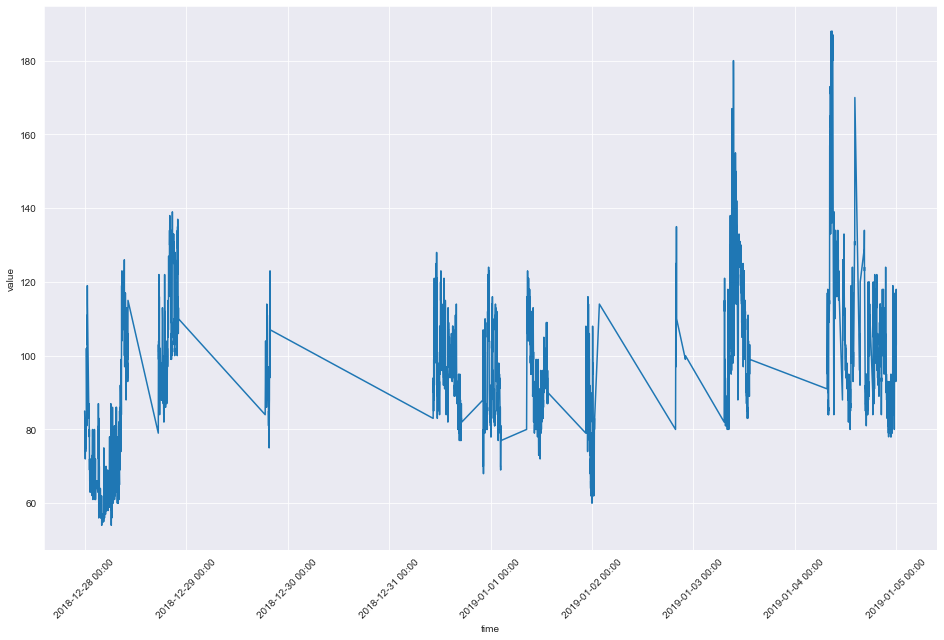

In [7]:

sns.set_style("darkgrid")


f,ax = plt.subplots(figsize = (16,10))
import seaborn as sns
sns.lineplot(x = 'time',y = 'value',data = test_rate)
# set formatter 
ax.xaxis.set_major_formatter(
    matplotlib.dates.DateFormatter("%Y-%m-%d %H:%M")
)
plt.xticks(rotation = 45)

## We have successfully pulled out the heart rate data across a date range. Yay! Next we will need to push our data into influxdb cloud. Influxdb is a time series data platform that is suitable for storing IoT data. 

Link on more information on time series database:
https://www.influxdata.com/time-series-database/

We will batch the data into chunks and push them into the cloud database 

Tutorial here: https://github.com/influxdata/influxdb-client-python/blob/master/examples/ingest_large_dataframe.py

In [ ]:
# configurations to push the heart rate data into influxdb cloud: 

# use your own configurations 
bucket = "my_bucket"
org = "my_org"
token = "my_token"
# Store the URL of your InfluxDB instance
url="https://ap-southeast-2-1.aws.cloud2.influxdata.com/"

According to the tutorial, we need to set the timestamp column as our index.

In [ ]:
# set the timestamp column as index 

test_heart_rate_to_influx= test_rate.set_index('time')

In [ ]:
with InfluxDBClient(url=url, token=token, org=org) as client: 
    
    with client.write_api(write_options=WriteOptions(
        # batch_size: number of data points to collect in a batch    
        batch_size=500,
        # flush interval: the numbmer of miliseconds before each batch is written to the cloud 
        flush_interval=10000,
        jitter_interval=2000,
        retry_interval=5000)) as write_client:
        
        write_client.write(bucket=bucket, org=org, record=test_heart_rate_to_influx,data_frame_measurement_name='value')
